# W UMa

Naším skromným cílem, je vykreslit si světelnou křivku dvou hvězd ukrývajících se pod společným názvem *VV UMa*. Proto si hned na začátku aktivujeme možnost vykreslování grafů přímo do této stránky.

In [1]:
%matplotlib inline

Dále si importujeme základní moduly pro interakci s prostředím nezávislé na operačním systému. Nepostradatelný modul `numpy` pro numerické výpočty a knihovnu `pyplot` pro vykreslovaní publikovatelných grafů. V neposlední řadě pak z naprosto klíčového modulu [`astropy`](http://www.astropy.org/) využijeme modul pro práci s FITS soubory, tedy dřívější [PyFITS](http://www.stsci.edu/institute/software_hardware/pyfits) dnes již zcela asimilovaný.

In [2]:
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits

Nastavíme si proměnnou s cestou k originálním datům, aby jsme ji nemuseli vypisovat celou ručně.

In [3]:
DATA = "20150317"

Abych vás netahal za nos, tak přiznám, že se nejedná o úplně původní data. Ty jsou bezpečně uloženy v archívů s volbou přístupových práv *pouze ke čtení*. Tyto jsou pro pohodlnější práci redukovány pomocí skriptu `binning2.py`, který jak jeho název napovídá, provedl jen a pouze jejich binning 2x2.

## Inspekce

Snímky si roztřídíme podle jednotlivých filtrů a setřídíme podle času pozorování.

In [4]:
R = sorted(glob.glob(os.path.join(DATA, "W_UMa*R*.fits")))
V = sorted(glob.glob(os.path.join(DATA, "W_UMa*V*.fits")))
B = sorted(glob.glob(os.path.join(DATA, "W_UMa*B*.fits")))

Jen pro zajímavost provedeme základní statistiku všech snímků. Proto si definujeme funkci, která jako argument přijme seznam snímků a na oplátku nám vrátí dva seznamy se středními hodnotami a standartními úchylkami pro každý ze snímků.

In [5]:
def statistika(seznam):
    Fmean = []
    Fstd = []
    for snimek in seznam:
        data = fits.getdata(snimek)
        Fmean.append(np.mean(data))
        Fstd.append(np.std(data))
    return Fmean, Fstd

Nyní můžeme naši novou funkci použít na seznamy snímků získané před chvílí.

In [6]:
Rmean, Rstd = statistika(R)
Vmean, Vstd = statistika(V)
Bmean, Bstd = statistika(B)

A po vykreslení do grafu...

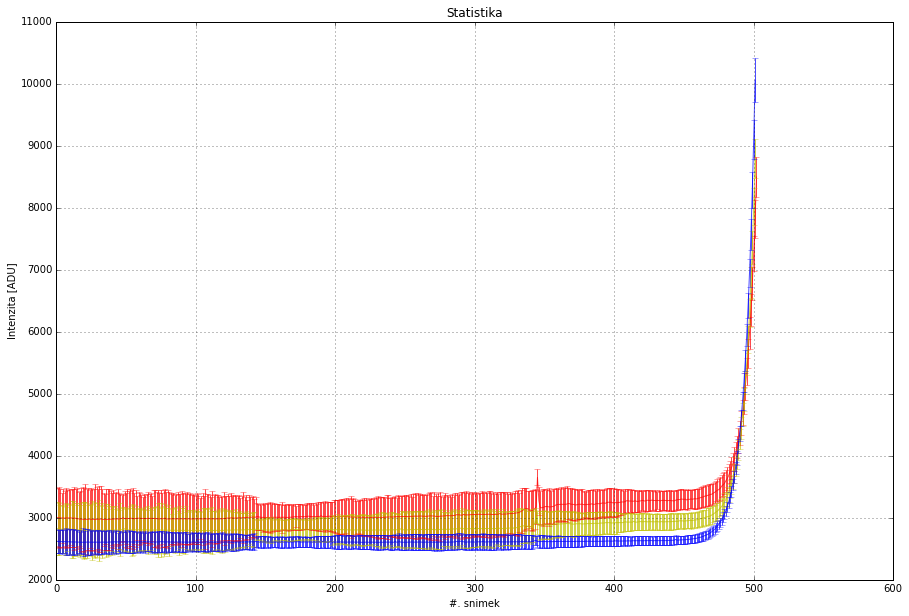

In [7]:
plt.figure(figsize=(15, 10))
plt.title("Statistika")
plt.xlabel("#. snimek")
plt.ylabel("Intenzita [ADU]")
plt.errorbar(range(len(R)), Rmean, Rstd, color="r", alpha=0.7)
plt.errorbar(range(len(V)), Vmean, Vstd, color="y", alpha=0.7)
plt.errorbar(range(len(B)), Bmean, Bstd, color="b", alpha=0.7)
plt.grid(True)

... hned vidíme, že skoro nic zajímavého se během noci nestalo. Jen ráno začalo svítat.

## Redukce

### Darky

Pokud mezi svými snímky nemůžete dárky najít a přesto jste si jistí, že jste je naprosto vyčerpaní po probdělé noci určitě nasnímali, tak se podívejte do adresářů z předchozích pozorovacích nocí. Díky SIPSi ;-)

In [8]:
darky = glob.glob(os.path.join(DATA, "dark_*.fits"))

Mohli by jsme se teď podívat do hlavičky každého dárku, přečíst si z ní hodnotu expozice a vybrat jen ty jedinečné, s přihlédnutím oka, že jedinečnost končí až na třetím nebo čtvrtém desetinném místě, ale protože si je pamatujeme, tak to dělat nemusíme. Tak jako tak tuto hodnotu z hlavičky číst budeme a rovnou si seznam takto roztříděných dárků zapíšeme do souborů.

In [18]:
for expozice in [10, 7, 5, 3, 2, 1]:
    with open("dark{}.lst".format(expozice), "w") as dlist:
        for dark in darky:
            if abs(fits.getval(dark, "EXPTIME") - expozice) < 1e-3:
                dlist.write(dark + "\n")

Několikrát 15 a jednou 21 jsou správná čísla, která bychom očekávali jako délky našich seznamů, tedy počty řádek ve výsledných souborech.

In [19]:
!wc -l dark*.lst

  14 dark1.lst
  15 dark10.lst
  15 dark2.lst
  15 dark3.lst
  15 dark5.lst
  21 dark7.lst
  95 celkem


### Flaty

Obdobně budeme pokračovat i pro flaty, které jsme pořídili ráno těsně před svítáním, 60° nad obzorem ve směru přímo proti Slunci, co na tom, že možná i na mracích.

In [20]:
flaty = glob.glob(os.path.join(DATA, "flat_rano*.fits"))

Zde je situace poněkud komplikovanější, neb musíme dát k sobě flaty se stejnou expozicí i odpovídajícím filterm, ale s tím si přidáním jednoho cyklu a jedné podmínky navíc lehce poradíme.

In [24]:
for expozice in [5, 3, 2, 1]:
    for filtr in ["R", "V", "B"]:
        with open("flat{}{}.lst".format(filtr, expozice), "w") as flist:
            for flat in flaty:
                if abs(fits.getval(flat, "EXPTIME") - expozice) < 1e-3 and \
                        fits.getval(flat, "FILTER") == filtr:
                    flist.write(flat + "\n")

Pokud is dobře pamatuji, stihli jsme udělat vždy dvě expozice pro různé časy v každém z filtrů.

In [25]:
!cat flatV1.lst

20150317/flat_rano_2015-03-18_04-43-25_V_0028.fits
20150317/flat_rano_2015-03-18_04-43-58_V_0031.fits


## Munipack

Od této chvíle redukci snímků přebírá [**Munipack**](http://munipack.physics.muni.cz/), což je

> A general astronomical image processing software

Detaily k jeho používání i podrobně popsaný postup redukce či kombinace snímků včetně testovacích dat naleznete on-line na stránkách projektu. Já se zde omezím jen na povrchní popis jeho použití a pokud to bude možné, budu spoléhat na výchozí chování, které je však v případě potřeby možno jemně doladit pomocí dodatečných voleb.

In [23]:
!munipack --help

Usage: munipack [--version] [-h] [--verbose] [action]

Actions:
 phcorr		Apply photometric precorrections
 bias		Averaged bias frame
 dark		Averaged dark frame
 flat		Averaged flat-field frame
 coloring	Compose color frame
 kombine	Compose frames (deep exposures, mosaics)
 ctrafo		Transform color frames between color-spaces
 cone		Cone search in a catalogue on Virtual Observatory
 astrometry	Astrometry calibration
 find		Search for stars on frames
 aphot		Aperture photometry
 phcal		Photometry calibration
 phfotran	Determine photometry system color transformation
 timeseries	List arbitrary quantity to time-series

Low Level Actions:
 votable	Conversions of VOTables
 fits		Operations on FITS files
 cross		Cross-match on FITS tables

  --version 	print version and license
  -h, --help	show this help message
  --verbose 	generate verbose log messages


## Linux, shell a MetaCentrum

Pojem *astronomické množsví dat* je myslím sám za sebe dostatečně vypovídající. Jejich robotické, tedy zcela automatické zpracování je, neváhám se řící, podmíněno použitím operačního systému typu **Unix**, který je už od svého vzniku koncipován pro samostatné provádění uživatelských příkazů. Následující příkazy uvozené znakem `!` stejně jako celé buňky označené magickým příkazem `%%bash` se bežně zadávají do tak zvaného okna terminálu přijímajícího příkazy shellu v operačním systému GNU/Linux. Nebo se dají zapsat do souboru v podobě skriptu a ten pak spouštět například v prostředí [MetaCentra](http://www.metacentrum.cz/cs/), které umožňuje alokovat dostatečné prostředky i pro paralerní běh náročnějších úloh.

Jelikož se `munipack` neustále vyvíjí a zlepšuje své možnosti, je vhodné používat alespoň jeho poslední vydanou verzi. Rychlejší opravy nalezených a nahlášených chyb se spíš dočkáte ve vývojové verzi vedené v `mercurial` repozitáři.

In [26]:
!munipack --version

Munipack 0.5.6, (C) 1997-2015 Filip Hroch <hroch@physics.muni.cz>
A general astronomical image processing software

  DEVELOPMENT VERSION (build: Mar 24 2015, 17:28:25)

Munipack comes with ABSOLUTELY NO WARRANTY.
You may redistribute copies of Munipack
under the terms of the GNU General Public License.
For more information about these matters, see the file named COPYING.


Protože `munipack` při každém kroku redukce snímků vytváři kopii originálu, exponenciálně tak ubývá volného místa na disku. Pro demonstrační účely je tak vhodné vypnou automatické zálohy.

In [37]:
!export VERSION_CONTROL=off

### Master Dark

In [38]:
!munipack dark --help

Usage: munipack dark [options] file(s)
* Averaged dark frame.
  -a                 	arithmetical instead of robust mean
  -bias:<str>        	bias frame
  --tol-temp=<double>	limit for nearby temperatures (1?C)
  --tol-exp=<double> 	limit for nearby exposure times (1?sec)
  -B, --bitpix=<num> 	bitpix (-32,32,16,8)
  -o, --output=<str> 	output file, (-) for stdout
  -b                 	make backup (default: on)
  --backup=<str>     	make and set backup method (default: existing)
  -S, --suffix=<str> 	suffix for backup (default: ~)
  -h, --help         	show this help message
  --verbose          	generate verbose log messages


Jako první krok si složíme jednotlivé dárky se stejnou expozicí. Varování o neznámé teplotě můžeme pro tentokrát ignorovat. I tu `munipack`, pokud ji najde pod správným klíčovým slovem v hlavičce snímku, kontroluje. Díky SIPSi ;-) My však víme, že teplota bylo to jediné, co se nám během noci neměnilo. Díky SIPSi ;-)

In [ ]:
%%bash
for i in 10 7 5 3 2 1
do
    munipack dark --verbose -o dark$i.fits @dark$i.lst
done

### Master Flat

In [39]:
!munipack flat --help

Usage: munipack flat [options] file(s)
* Averaged flat-field frame.
  -bias:<str>        	bias frame
  -dark:<str>        	dark frame
  -xdark:<double>    	dark frame multiplicator factor
  -gain:<double>     	provide value of gain (rather than FITS keyword)
  --gain-estimate    	estimate gain
  --level=<double>   	output mean level (default 1.0)
  --saturate=<double>	saturation in ADU
  -B, --bitpix=<num> 	bitpix (-32,32,16,8)
  -o, --output=<str> 	output file, (-) for stdout
  -b                 	make backup (default: on)
  --backup=<str>     	make and set backup method (default: existing)
  -S, --suffix=<str> 	suffix for backup (default: ~)
  -h, --help         	show this help message
  --verbose          	generate verbose log messages


Za další si pro každý filtr složíme vždy oba flaty se stejnou expozicí s odečteným patřičným dárkem.

In [ ]:
%%bash
for f in R V B
do
    for i in 5 3 2 1
    do
        munipack flat --verbose -dark dark$i.fits -o flat$f$i.fits @flat$f$i.lst
    done
done

A všechny čtyři flaty pro každý filtr spojíme v jeden výsledný.

In [ ]:
%%bash
for f in R V B
do
    munipack flat --verbose -o flat$f.fits flat$f?.fits
done

### Seznamy snímků poprvé

Pro pohodlnější práci si napřed uložíme seznamy snímků v jednotlivých filtrech do souborů.

In [40]:
%%bash
DATA=20150317
find $DATA/W_UMa*R*.fits > R.lst
find $DATA/W_UMa*V*.fits > V.lst
find $DATA/W_UMa*B*.fits > B.lst

In [41]:
!head R.lst

20150317/W_UMa_2015-03-17_20-47-37_R_0000.fits
20150317/W_UMa_2015-03-17_20-48-28_R_0003.fits
20150317/W_UMa_2015-03-17_20-49-19_R_0006.fits
20150317/W_UMa_2015-03-17_20-50-09_R_0009.fits
20150317/W_UMa_2015-03-17_20-51-00_R_0012.fits
20150317/W_UMa_2015-03-17_20-51-51_R_0015.fits
20150317/W_UMa_2015-03-17_20-52-42_R_0018.fits
20150317/W_UMa_2015-03-17_20-53-32_R_0021.fits
20150317/W_UMa_2015-03-17_20-54-23_R_0024.fits
20150317/W_UMa_2015-03-17_20-55-14_R_0027.fits


### Fotometricka korekce

In [42]:
!munipack phcorr --help

Usage: munipack phcorr [options] file(s)[,result(s)]
* Apply photometric precorrections (gain, bias, dark, flat-field).
  -flat:<str>                 	flat-field frame
  -bias:<str>                 	bias frame
  -dark:<str>                 	dark frame
  -xdark:<double>             	dark frame multiplicator factor
  -bitmask:<str>              	mask frame
  -xbitmask:<str>             	mask frame as ZERO (default), MEAN (average)
  -gain:<double>              	provide value of gain (rather than FITS keyword)
  --gain-ignore               	ignore gain transformation
  --normalise                 	Normalise on averaged flat-field level
  --force                     	apply to already corrected frames
  --tol-temp=<double>         	limit for nearby temperatures (1?C)
  --tol-exp=<double>          	limit for nearby exposure times (1?sec)
  -B, --bitpix=<num>          	bitpix (-32,32,16,8)
  -b                          	make backup (default: on)
  --backup=<str>              	make and set bac

Nyní můžeme provést základní fotometrickou korekci našich snímků. Tedy odečtění dárku a podělení flatem. Výsledné snímky se uloží do aktuálního adresáře. Určitě stojí za to, si alespoň jeden z nich prohlédnout na vlastní oči a prozkoumat jak se jeho struktura postupně mění po každém kroku zpracování.

In [ ]:
%%bash
munipack phcorr --verbose -t . -flat flatR.fits -dark dark7.fits @R.lst &
munipack phcorr --verbose -t . -flat flatV.fits -dark dark7.fits @V.lst &
munipack phcorr --verbose -t . -flat flatB.fits -dark dark7.fits @B.lst &
wait

### Seznamy snímků podruhé

Než budeme pokračovat, tak si opět do souborů vypíšeme nově vziknuvší snímky.

In [43]:
!ls W_UMa_*_R_????.fits > R.lst
!ls W_UMa_*_V_????.fits > V.lst
!ls W_UMa_*_B_????.fits > B.lst

In [44]:
!head R.lst

W_UMa_2015-03-17_20-47-37_R_0000.fits
W_UMa_2015-03-17_20-48-28_R_0003.fits
W_UMa_2015-03-17_20-49-19_R_0006.fits
W_UMa_2015-03-17_20-50-09_R_0009.fits
W_UMa_2015-03-17_20-51-00_R_0012.fits
W_UMa_2015-03-17_20-51-51_R_0015.fits
W_UMa_2015-03-17_20-52-42_R_0018.fits
W_UMa_2015-03-17_20-53-32_R_0021.fits
W_UMa_2015-03-17_20-54-23_R_0024.fits
W_UMa_2015-03-17_20-55-14_R_0027.fits


### Hledání hvězd

In [45]:
!munipack find --help

Usage: munipack find [options] file(s)[,results(s)]
* Search for stars on frames.
  -f, --fwhm=<double>         	FWHM in pixels
  -th, --threshold=<double>   	threshold in sigmas above background
  --saturate=<double>         	saturation in ADU
  --lothresh=<double>         	lower for threshold in sigmas
  --rndlo=<double>            	lower for round
  --rndhi=<double>            	higher for round
  --shrplo=<double>           	lower for sharp
  --shrphi=<double>           	higher for sharp
  --read-noise=<double>       	read noise in ADU (default: frame header)
  --remove                    	remove find table
  -b                          	make backup (default: on)
  --backup=<str>              	make and set backup method (default: existing)
  -S, --suffix=<str>          	suffix for backup (default: ~)
  -t, --target-directory=<str>	set target directory
  -O                          	switch-on advanced output filenames processing
  --pattern=<str>             	matching pattern (for -O

Prvním krokem je nalezení hvězd na snímku. Pokud hledací algoritmus selhává pro příliš slabé, nebo naopak jasné hvězdy, lze jeho chování ovlivnit nastavením parametrů pro plno-šířku v polo-výšce gaussova profilu hvězdy a prahovou hodnotou v násobcích sigma nad pozadím snímku.

In [ ]:
%%bash
munipack find --verbose -f 8 @R.lst &
munipack find --verbose -f 8 -th 9 @V.lst &
munipack find --verbose -f 11 -th 13 @B.lst &
wait

Pokud vás zajímá, kolik hvězd se na každém snímku našlo, tak to lze zjistit jako počet řádků tabulky se sáznamy o nalazených hvězdách v nově vytvořené extenzi našich snímků.

In [47]:
def hvezdy(seznam):
    pocet = []
    for snimek in seznam:
        pocet.append(fits.getval(snimek, "NAXIS2", extname="FIND"))
    return pocet

In [48]:
R = sorted(glob.glob("W_UMa*R*_????.fits"))
NR = hvezdy(R)

V = sorted(glob.glob("W_UMa*V*_????.fits"))
NV = hvezdy(V)

B = sorted(glob.glob("W_UMa*B*_????.fits"))
NB = hvezdy(B)

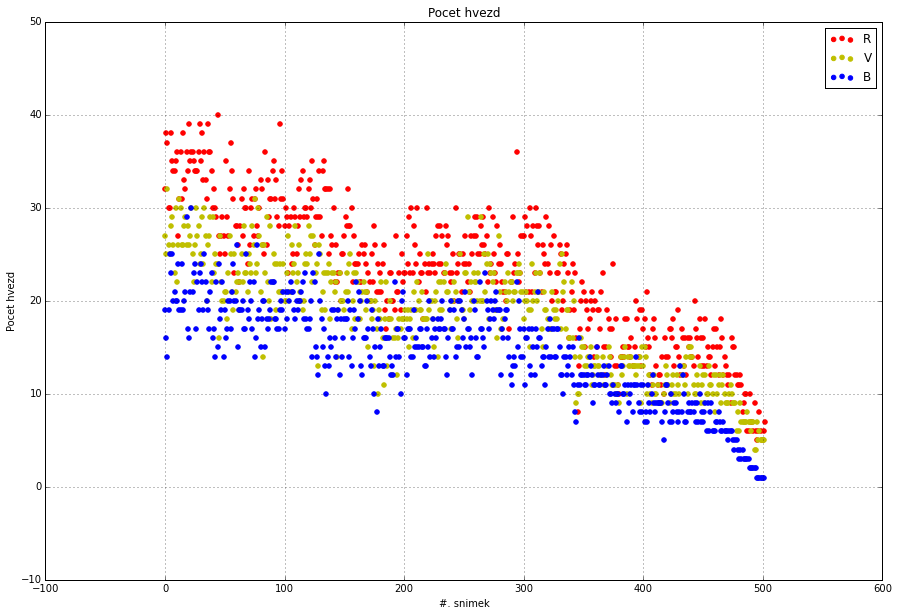

In [52]:
plt.figure(figsize=(15, 10))
plt.title("Pocet hvezd")
plt.xlabel("#. snimek")
plt.ylabel("Pocet hvezd")
plt.scatter(range(len(R)), NR, color="r", label="R")
plt.scatter(range(len(V)), NV, color="y", label="V")
plt.scatter(range(len(B)), NB, color="b", label="B")
plt.grid(True)
plt.legend()

### Aperturní fotometrie

In [53]:
!munipack aphot --help

Usage: munipack aphot [options] file(s)[,results(s)]
* Aperture photometry
  -s, --saper=<num>           	select aperture number
  --apertures=<str>           	a1,a2,... define aperture radii in pixels 
  --ring=<str>                	ri,ro inner and outer sky ring radius in pixels 
  --remove                    	remove aperture photometry table
  -b                          	make backup (default: on)
  --backup=<str>              	make and set backup method (default: existing)
  -S, --suffix=<str>          	suffix for backup (default: ~)
  -t, --target-directory=<str>	set target directory
  -O                          	switch-on advanced output filenames processing
  --pattern=<str>             	matching pattern (for -O)
  --mask=<str>                	mask for output file(s) (for -O)
  --format=<str>              	format for output files (for -O)
  -h, --help                  	show this help message
  --verbose                   	generate verbose log messages


Nyní můžeme přejít k aperturní fotometrii nalezených hvězd.

In [ ]:
%%bash
munipack aphot --verbose @R.lst &
munipack aphot --verbose @V.lst &
munipack aphot --verbose @B.lst &
wait

### Virtuální Observatoř

Pro další postup potřebujeme znát souřadnice přibližně středu snímku. V našem případě si bohatě vystačíme i se samotnými souřadnicemi naší hvězdy, které se nám navíc později budou ještě jednou hodit. Zde nám v případě fungujicího internetu poslouží integrace balíku `astropy` s Virtuální Observatoří.

In [54]:
from astropy.coordinates import SkyCoord
SkyCoord.from_name("W UMa")

<SkyCoord (ICRS): (ra, dec) in deg
    (145.93945254, 55.95252106)>

In [3]:
!munipack cone --help

Usage: munipack cone [options] [--] RA DEC
* Cone search in catalogues of Virtual Observatory.
  -c, --cat=<str>      	catalogue (see --list-catalogues)
  -r, --radius=<double>	radius for cone search [deg] (default 0.1)
  -s, --sort=<str>     	sort by the column
  --par=<str>          	add optional parameters
  --url=<str>          	service URL
  --id=<str>           	catalogue identifier
  --server=<str>       	Virtual observatory server (see --list-servers)
  --list-catalogues    	show available catalogues
  --list-servers       	show available VO servers
  --vocat=<str>        	configuration file
  --type=<str>         	type of output file: fits,csv,txt,xml
  -o, --output=<str>   	output file, (-) for stdout
  -b                   	make backup (default: on)
  --backup=<str>       	make and set backup method (default: existing)
  -S, --suffix=<str>   	suffix for backup (default: ~)
  -h, --help           	show this help message
  --verbose            	generate verbose log messages


S Virtuální Observatoří komunikuje i samotný `munipack`, který si od ní vyžádá katalog hvězd v daném okolí zadaných souřadnic.

In [55]:
!munipack cone --verbose -r 0.2 145.93945254 55.95252106

Debug: Launching `cone' ...
Debug: VERBOSE = T
Debug: OUTPUT = 'cone.fits' 'cone.fits~'
Debug: URL = 'http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=I/322&RA=145.939&DEC=55.9525&SR=0.2&VERB=3'
Debug: SORT = 'f.mag'
Debug: MuniProcess::OnFinish: 81411 0
Connecting VO: http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=I/322&RA=145.939&DEC=55.9525&SR=0.2&VERB=3
Cone search: 59 objects found
STOP 0
Debug: MuniPipe::OnFinish 81411 0
Debug: Remaning processes: 0


### Astrometrie

In [56]:
!munipack astrometry --help

Usage: munipack astrometry [options] file(s)[,results(s)]
* Astrometry calibration.
  -c, --cat=<str>             	catalogue
  -r, --ref=<str>             	reference frame
  -R, --rel=<str>             	reference frame (relative)
  -p, --projection=<str>      	projection: identity, gnomonic (default)
  --col-ra=<str>              	Right Ascension column
  --col-dec=<str>             	Declination column
  --col-pm-ra=<str>           	Proper motion in Right Ascension column
  --col-pm-dec=<str>          	Proper motion in Declination column
  --col-mag=<str>             	Magnitude-like column
  --xcen=<double>             	center of frame [pix] (default: width/2)
  --ycen=<double>             	center of frame [pix] (default: height/2)
  --rcen=<double>             	center of FOV in Right Ascension [deg]
  --dcen=<double>             	center of FOV in Declination [deg]
  --scale=<double>            	scale [deg/pix]
  --angle=<double>            	position angle [deg]
  --fit=<str>          

Astrometrie na snímcích se provádí srovnáním detekovaných hvězd s právě získaným katalogem. Pokud je úspěšná, je její výsledek zapsán do hlavičky snímku v podobě standartních WCS klíčových slov.

In [ ]:
%%bash
munipack astrometry --verbose -c cone.fits @R.lst &
munipack astrometry --verbose -c cone.fits @V.lst &
munipack astrometry --verbose -c cone.fits @B.lst &
wait

### Absolutní fotometrie

Pro absolutní fotometrickou kalibraci je potřeba srovnávací katalog. Pokud jsme si vlastní observační přístrojovou konfigurací svůj nevytvořili, třeba kalibrací pomocí standartních fotometrických polí, můžeme opět použít ten získaný v předchozím kroku z Virtuální Observatoře. Jen je v něm třeba dopočítat chybějící hvězdné velikosti R a I Johnsonova fotometrického systému. K tomu poslouří následující mírně upravený kód, který je opět k nalezení na www stránkách `munipack`u.

In [60]:
from astropy.io import fits as pyfits


def ucac_jmuc(ucac,jmuc):

    # converts UCAC4 r,i in Gunn to R,I of Johnson's

    fits = pyfits.open(ucac)
    rmag = fits[1].data['rmag']
    imag = fits[1].data['imag']
    e_rmag = fits[1].data['e_rmag']
    e_imag = fits[1].data['e_imag']

    # http://www.sdss.org/dr4/algorithms/sdssUBVRITransform.html
    # Lupton (2005)
    rjmag = rmag - 0.2936*(rmag - imag) - 0.1439
    ijmag = rmag - 1.2444*(rmag - imag) - 0.3820

    cr = pyfits.Column('Rmag','1E','mag',array=rjmag)
    ci = pyfits.Column('Imag','1E','mag',array=ijmag)
    cre = pyfits.Column('e_Rmag','1E','cmag',array=e_rmag)
    cie = pyfits.Column('e_Imag','1E','cmag',array=e_imag)

    # removing old ones to prevent duplicity (case insensitive)
    d = pyfits.ColDefs(fits[1].data)
    d.del_col('rmag')
    d.del_col('imag')
    d.del_col('e_rmag')
    d.del_col('e_imag')

    nt = pyfits.new_table(d)

    cols = nt.columns + cr + cre + ci + cie
    f = pyfits.new_table(cols)
    f.writeto(jmuc)

Po provedení následujícího příkazu získáme nový katalog, jen mírně odlišný od původního.

In [61]:
ucac_jmuc("cone.fits", "mycone.fits")

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [__main__]
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [__main__]
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.


In [62]:
!munipack phcal --help

Usage: munipack phcal [options] file(s)[,results(s)]
* Photometry calibration.
  -C, --cal=<str>             	specify the calibration ratio(s) by hand
  -c, --cat=<str>             	reference photometry catalogue
  -r, --ref=<str>             	reference frame
  -f, --filters=<str>         	list of filters
  --col-ra=<str>              	Right Ascension column
  --col-dec=<str>             	Declination column
  --col-mag=<str>             	magnitude column(s)
  --col-magerr=<str>          	magnitude std. error column(s)
  --photsys-ref=<str>         	reference photometry system (catalogue)
  --photsys-instr=<str>       	instrumental photometry system (frames)
  --area=<double>             	area of input aperture [m2]
  -q, --quantity=<str>        	select: PHRATE,FLUX,FNU,FLAM,MAG,ABMAG,STMAG
  --tratab=<str>              	instrumental to reference photo-system table
  --phsystab=<str>            	photometry systems definition table
  --list                      	show available photometry

Nyní již nastal čas na samotnou absolutní fotometri snímků. Ta představuje stěžejní bod veškeré inteligence `munipack`u. Pokud se chcete o jejich technikách dozvědět více podrobností, nezbyde vám, než se začíst do on-line/off-line dokumentace či ještě hlouběji do jeho samotného zdrojového kódu, který je rovněž volně dostupný.

In [ ]:
%%bash
for f in R V B
do
    for s in `cat $f.lst`
    do
        munipack phcal --verbose -c mycone.fits --photsys-ref "Johnson" --filters $f --col-ra RAJ2000 --col-dec DEJ2000 --col-mag ${f}mag --col-magerr e_${f}mag --photsys-instr "MonteBoo" --area 0.3 $s
    done
done

### Časová řada

In [63]:
!munipack timeseries --help

Usage: munipack timeseries [options] [RA,Dec] ... file(s)
* List anything to time-series.
  -c, --column=<str>   	column name(s) to list
  -C, --coocolumn=<str>	column name(s) of coordinates (object search)
  -x, --extname=<str>  	FITS extension identificator
  -T, --time-type=<str>	JD (default), MJD, HJD, PHASE
  --time-stamp=<str>   	MID (default), BEGIN, END
  --time-err=<double>  	uncertainty in the time measurement [s]
  --time-res=<double>  	resolution in the time measurement [s]
  --epoch=<double>     	reference time for light curve elements [JD]
  --period=<double>    	period light curve elements [days]
  --tol=<double>       	search radius [deg]
  --coo-type=<str>     	DEG (default), RECT
  --cat=<str>          	coordinates from the FITS file
  --stdout             	print results also to standard output
  -o, --output=<str>   	output file, (-) for stdout
  -b                   	make backup (default: on)
  --backup=<str>       	make and set backup method (default: existing)
  -

Posledním krokem k získání světelné křivky je spočtení hodnoty Juliánského data a hvězdné velikosti z kalibrovaných snímků pro hvězdu identifikovanou jejími souřadnicemi a jejich uložení do souborů pro další zpracování.

In [ ]:
%%bash
for f in R V B
do
    munipack timeseries --stdout -c mag,magerr 145.93945254,55.95252106 W_UMa*$f*_cal.fits > $f.dat
done

## Světelná křivka

Po načtení dat ze souborů.

In [64]:
JDR, Rmag, Rerr = np.loadtxt("R.dat", unpack=True)
JDV, Vmag, Verr = np.loadtxt("V.dat", unpack=True)
JDB, Bmag, Berr = np.loadtxt("B.dat", unpack=True)

Již můžeme přejít k samotnému vykreslení světelných křivek ve všech filtrech.

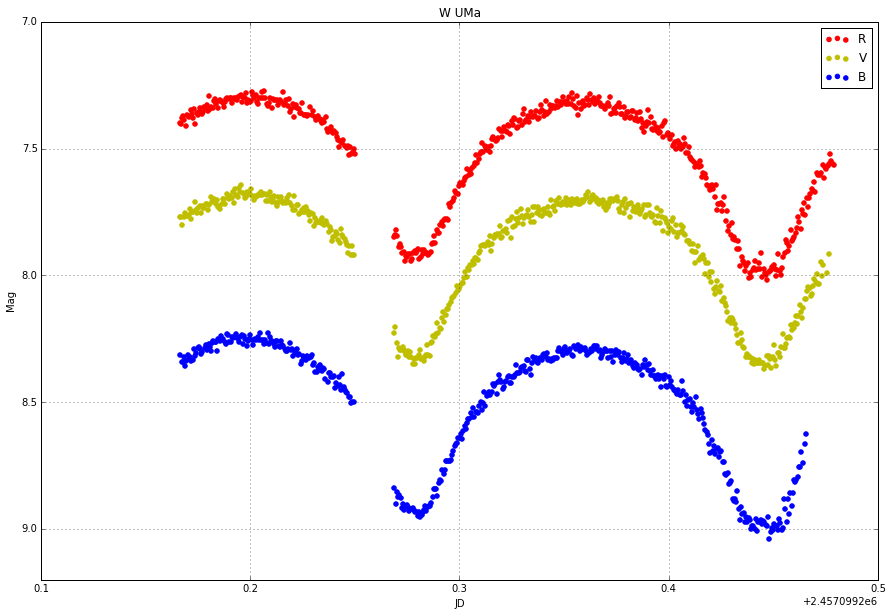

In [73]:
plt.figure(figsize=(15,10))
plt.title("W UMa")
plt.xlabel("JD")
plt.ylabel("Mag")
plt.ylim([7, 9.2])
plt.gca().invert_yaxis()
plt.scatter(JDR, Rmag, color="r", label="R")
plt.scatter(JDV, Vmag, color="y", label="V")
plt.scatter(JDB, Bmag, color="b", label="B")
plt.grid(True)
plt.legend()

A žasnout nad jejich ladností, jen místy narušenou samovolným přerušením série expozic. Díky SIPSi ;-)

## Přesnost dalekohledu

Zajímavou informací, je i přesnost a stabilita dalekohledu, kterou můžeme odvodit z pozice hvězdy na snímku během ničím nerušeného celonočního pozorování.

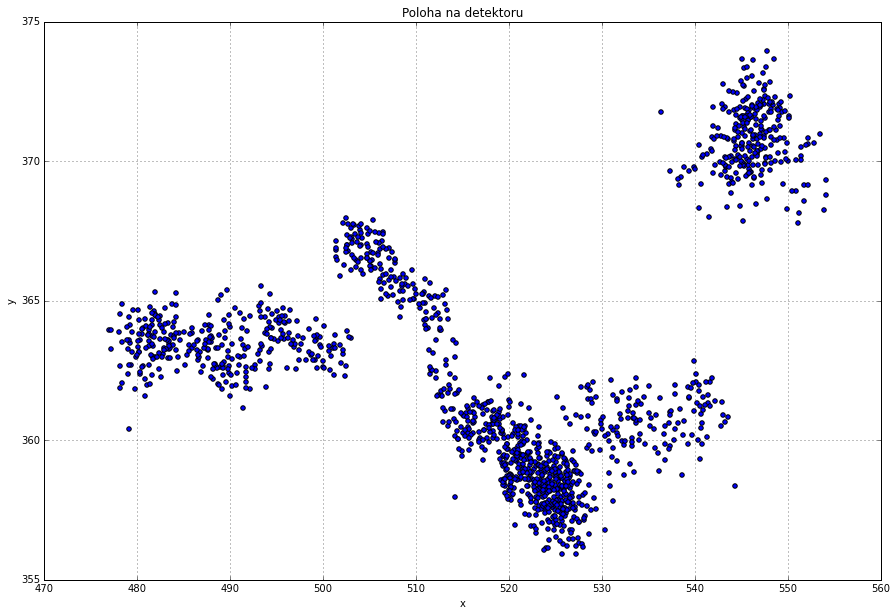

In [72]:
x, y = np.loadtxt("xy.dat", unpack=True)

plt.figure(figsize=(15, 10))
plt.title("Poloha na detektoru")
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x, y)
plt.grid(True)

* * *

"THE BEER-WARE LICENSE" (Revision 42):<br/>
<janak@physics.muni.cz> wrote this file. As long as you retain this notice
you can do whatever you want with this stuff. If we meet some day, and you
think this stuff is worth it, you can buy me a beer in return Zdeněk Janák